# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Set a seed for reproducibility
np.random.seed(42)
# Load the dataset
skin_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
SIZE=32

In [ ]:
# Encode labels using LabelEncoder
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

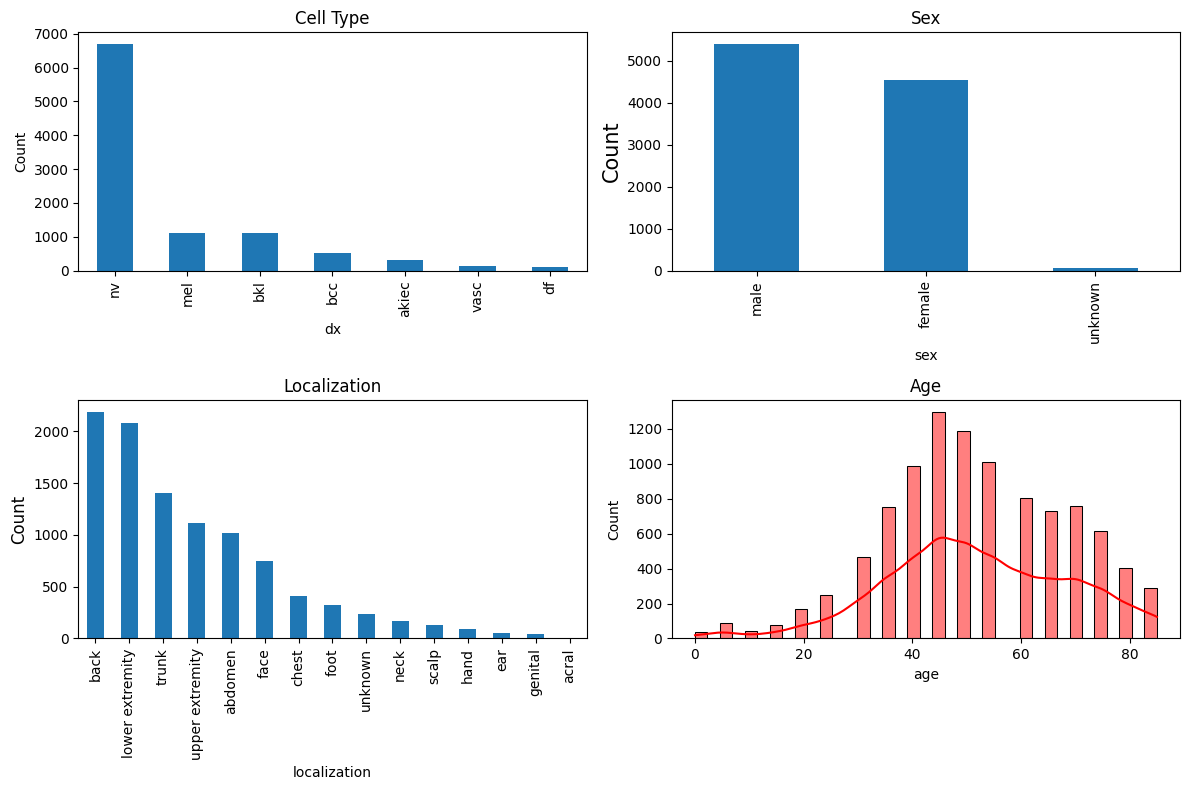

In [ ]:
# Plotting distribution of cell types, sex, localization, and age
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.histplot(sample_age['age'], kde=True, color='red', ax=ax4);
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [ ]:
# Labeling
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [ ]:
# Upsample the minority class to balance the dataset
n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)


In [ ]:
# Combine the balanced dataframes
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [ ]:
skin_df_balanced['label'].value_counts()

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64

In [ ]:
# Create a dictionary to map image IDs to file paths
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/kaggle/input/skin-cancer-mnist-ham10000', '*', '*.jpg'))}

In [ ]:
# Add 'path' and 'image' columns to the balanced dataframe
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [ ]:
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

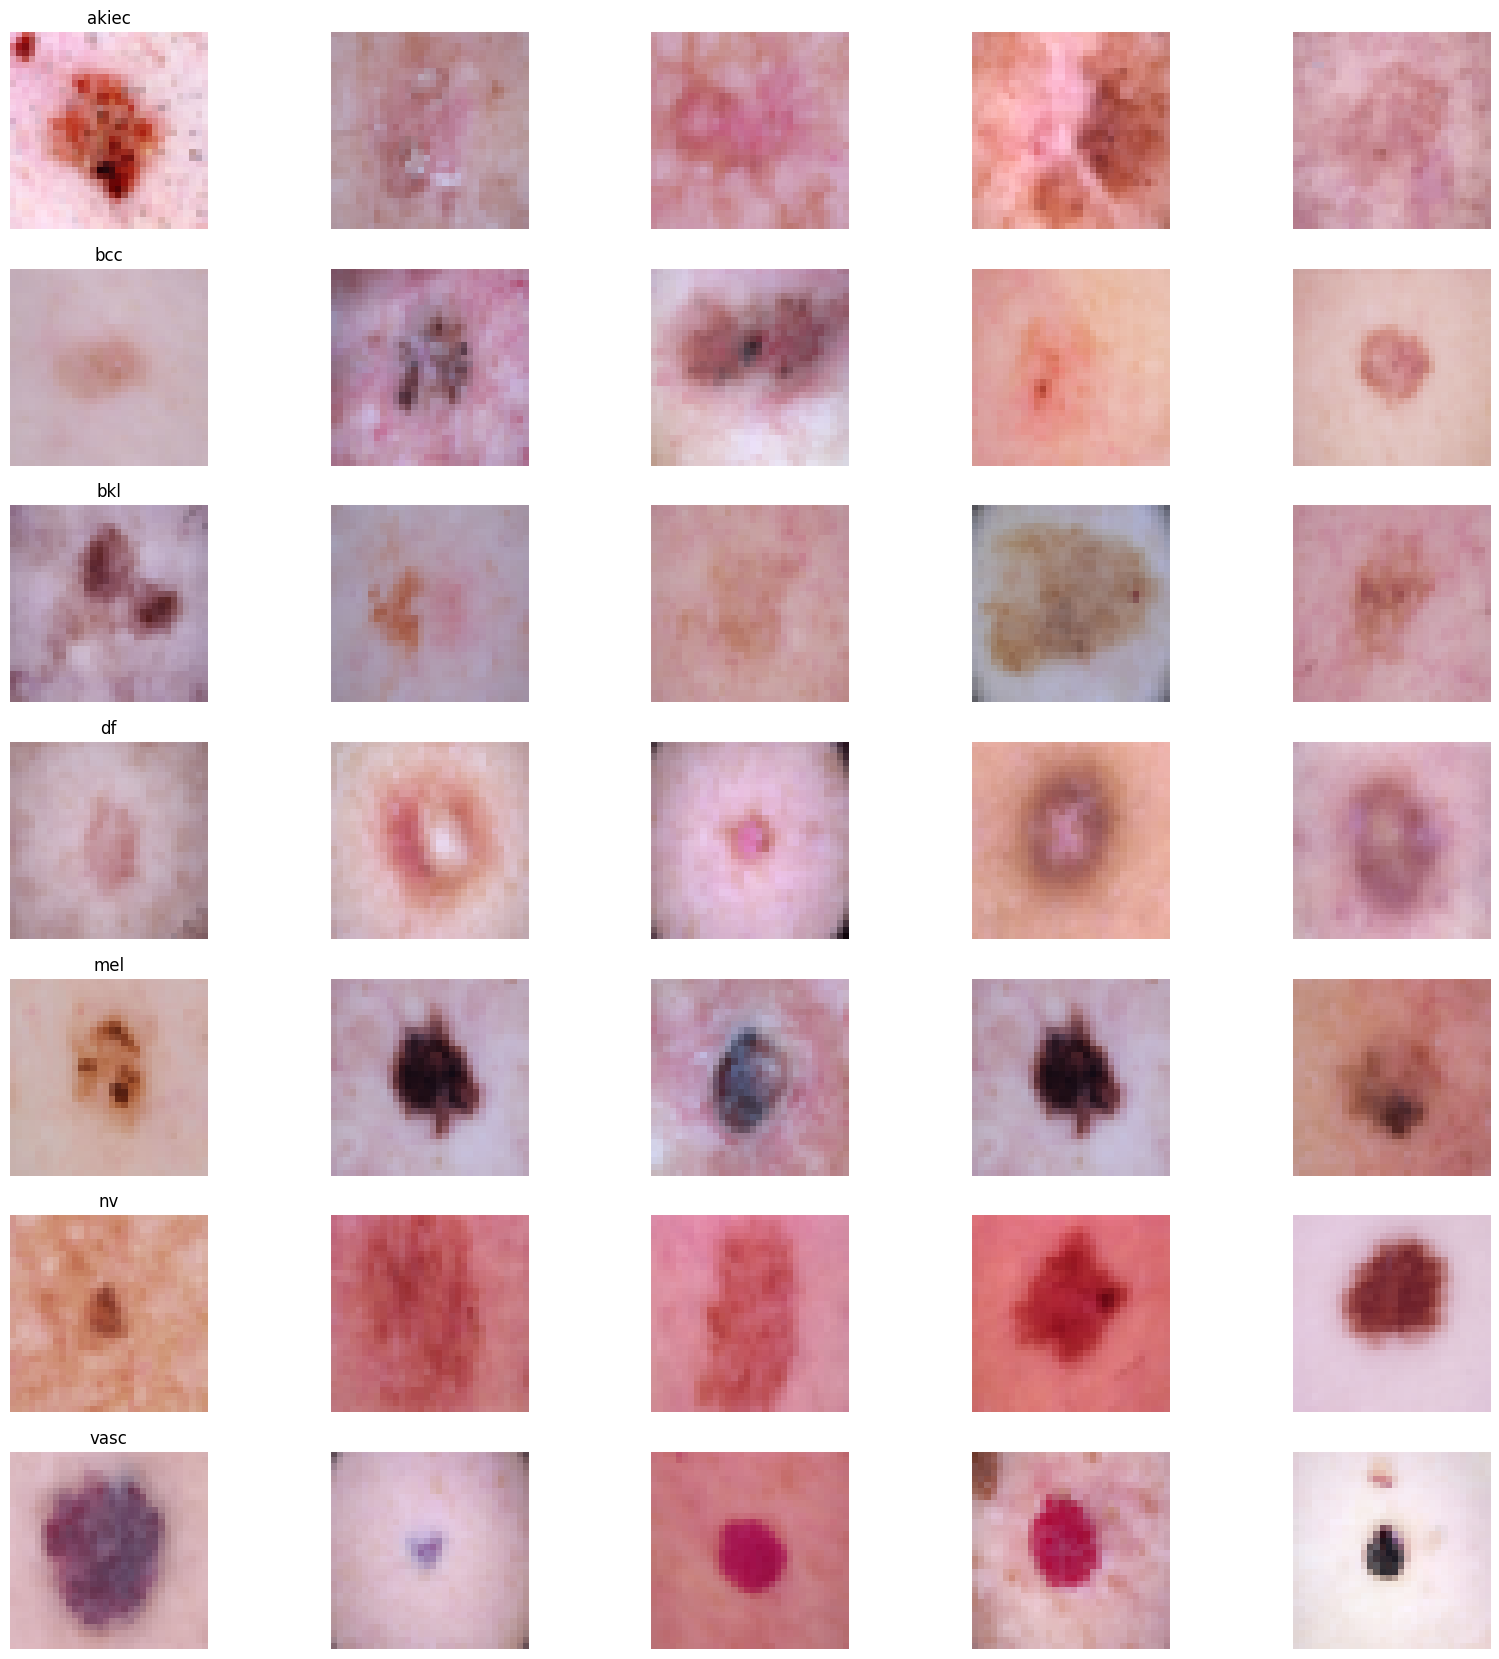

In [ ]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

## ANN

In [ ]:
num_classes = 7
model_ann = Sequential()
model_ann.add(Dense(256, input_shape=(SIZE, SIZE, 3), activation='relu'))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dense(64, activation='relu'))
model_ann.add(Dense(32, activation='relu'))
model_ann.add(Dropout(0.1))
model_ann.add(Flatten())
model_ann.add(Dense(num_classes, activation='softmax'))
model_ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32, 32, 256)       1024      
                                                                 
 dense_6 (Dense)             (None, 32, 32, 128)       32896     
                                                                 
 dense_7 (Dense)             (None, 32, 32, 64)        8256      
                                                                 
 dense_8 (Dense)             (None, 32, 32, 32)        2080      
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 7)                

In [ ]:
model_ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Train the model
batch_size = 16
epochs = 20

history_ann = model_ann.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2
)

Epoch 1/20
165/165 - 15s - loss: 1.8007 - acc: 0.2754 - val_loss: 1.7727 - val_acc: 0.3143 - 15s/epoch - 89ms/step
Epoch 2/20
165/165 - 13s - loss: 1.4588 - acc: 0.4366 - val_loss: 1.4915 - val_acc: 0.4640 - 13s/epoch - 76ms/step
Epoch 3/20
165/165 - 13s - loss: 1.2327 - acc: 0.5421 - val_loss: 1.2639 - val_acc: 0.5417 - 13s/epoch - 80ms/step
Epoch 4/20
165/165 - 13s - loss: 1.0948 - acc: 0.5855 - val_loss: 1.2036 - val_acc: 0.5806 - 13s/epoch - 76ms/step
Epoch 5/20
165/165 - 13s - loss: 0.9432 - acc: 0.6613 - val_loss: 1.1102 - val_acc: 0.6229 - 13s/epoch - 76ms/step
Epoch 6/20
165/165 - 13s - loss: 0.8437 - acc: 0.7090 - val_loss: 1.1096 - val_acc: 0.6160 - 13s/epoch - 79ms/step
Epoch 7/20
165/165 - 13s - loss: 0.7419 - acc: 0.7341 - val_loss: 1.0119 - val_acc: 0.6766 - 13s/epoch - 78ms/step
Epoch 8/20
165/165 - 13s - loss: 0.6549 - acc: 0.7676 - val_loss: 1.1698 - val_acc: 0.6331 - 13s/epoch - 79ms/step
Epoch 9/20
165/165 - 13s - loss: 0.5975 - acc: 0.7950 - val_loss: 1.0274 - val_a

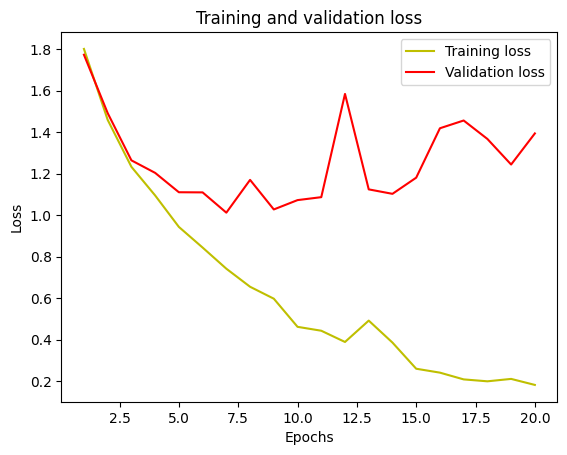

In [ ]:
loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

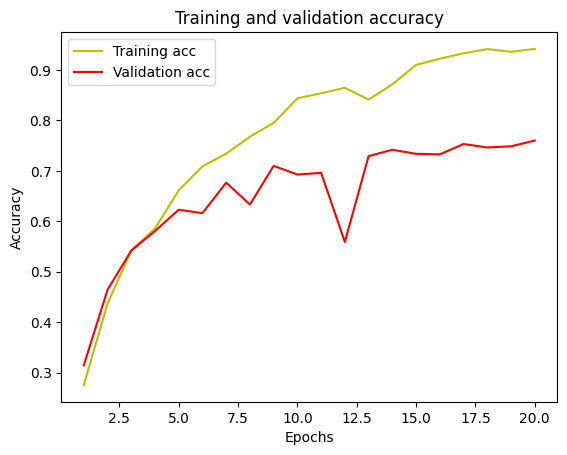

In [ ]:
acc = history_ann.history['acc']
val_acc = history_ann.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Prediction on test data
y_pred = model_ann.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

28/28 [==============================] - 1s 42ms/step


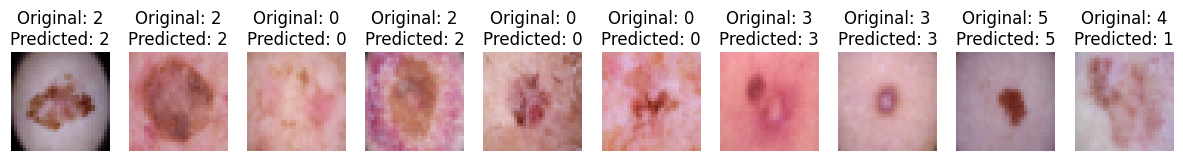

In [ ]:
n_samples_to_display = 10
# Get random indices
random_indices = np.random.choice(range(len(x_test)), size=n_samples_to_display, replace=False)

# Plot the images
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, n_samples_to_display, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f'Original: {np.argmax(y_test[idx])}\nPredicted: {y_pred_classes[idx]}')
    plt.axis('off')

plt.show()

In [ ]:
# Save the model for later use
model_ann.save("Skin_disease_ann1.h5")